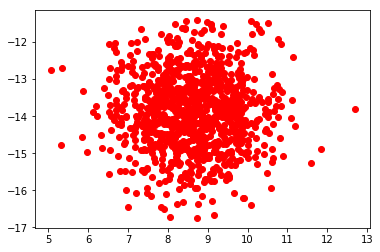

In [668]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import math

#X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=0)
X, y = make_blobs(n_samples=50000, n_features=2, centers=1, cluster_std=1.0,center_box=(-20.0, 20.0))

X = np.array(X)


plt.plot(X[:, 0], X[:, 1], 'ro')
plt.show()

In [803]:
X, y = make_blobs(n_samples=50000, n_features=2, centers=1, cluster_std=1.0, center_box=(-20.0, 20.0))

X = np.array(X)
print(X)

[[-1.88781696 -6.54102522]
 [-2.93211809 -6.91101528]
 [-3.79724656 -7.51546396]
 ..., 
 [-4.05309715 -5.67173783]
 [-2.4140339  -7.38233659]
 [-3.95552091 -4.83334162]]


In [804]:
class node(object):
 
    def __init__(self, weights_lenght, x, y):
        self.weights_lenght = weights_lenght;
        self.weights = np.random.rand(1, weights_lenght)[0];
        
        #print("WEIGHTS", self.weights )
        #self.weights = normalize(self.weights.reshape(1, -1))[0];
        #self.weights = np.random.randint();
        self.x_coord = x;
        self.y_coord = y;
        self.updated = False; 

   
    def weight_distance(self, node_weights):
        distance_array = self.weights - node_weights;
        distance_array = distance_array*distance_array; 
        distance = np.sum(distance_array)
        return math.sqrt(distance);
 
    def distance(self, x, y):
        distance = (self.x_coord - x)*(self.x_coord - x)+(self.y_coord - y)*(self.y_coord - y);
        return math.sqrt(distance);
    
    def adjust_weights(self, data_row, learning_rate, influence):
        #print("SIZE: ", len(self.weights[:,0]))
        self.updated = True;
        #print(data_row,self.weights)
        self.weights = self.weights + learning_rate * influence * (data_row - self.weights);
        #self.weights = normalize(self.weights.reshape(1, -1))[0];
        #print(data_row,self.weights)
    
    def plot(self):
        plt.plot(self.x_coord, self.y_coord, 'ro')
        plt.show()
        
    def print_weights(self):
        print(self.weights)
        
    def get_weights(self):
        return self.weights;
    
    def get_x(self):
        return self.x_coord;
    
    def get_y(self):
        return self.y_coord;
    
    def is_updated(self):
        return self.updated;
    

In [805]:
class SOM(object):

    def __init__(self, data, data_row_size, size_row, size_col):            
        self.SOM_grid = [];
        self.SOM_grid_pos = [];
        self.size_row = size_row;
        self.size_col = size_col;
        self.data = data;
        for i in range(0, size_col):
            for j in range(0, size_row): 
                self.SOM_grid.append(node(data_row_size, i, j));
                #self.SOM_grid_pos.append([j, i])
        #plt.plot(self.SOM_grid_pos, 'ro')
        #plt.show()
        
            
    def learn(self, data, num_iterations, start_learning_rate):
        
        map_radius = max(self.size_row, self.size_col)/2;
        time_constant = num_iterations/float(math.log(map_radius));
        learning_rate = start_learning_rate; 
        iteration_count = 0;
        self.data = data;
        #self.plot()
        count = num_iterations;
        while num_iterations > 0: 
           
            iteration_count= iteration_count + 1;
            rand_point = np.random.randint(0, data[:,0].size); 
            data_row = data[rand_point];
            data = np.delete(data, (rand_point), axis=0)
            
            winning_node = self.best_matching_node(data_row);
            neighbourhood_radius = map_radius * math.exp(-iteration_count/time_constant);
            #neighbourhood_radius = map_radius - 1;
            #print("______________________________________")
            for i in range(0, len(self.SOM_grid)):

                curr_dist_to_bmu = self.SOM_grid[i].distance(winning_node.get_x(), winning_node.get_y());
                curr_dist_to_bmu_sqrt = curr_dist_to_bmu*curr_dist_to_bmu;
                neighbourhood_radius_sqrt = neighbourhood_radius*neighbourhood_radius;
                # WORKS FINE print("Neighbourhood: ", neighbourhood_radius_sqrt)
                #print("BMU", winning_node.get_x(), winning_node.get_y())
                if curr_dist_to_bmu_sqrt < neighbourhood_radius_sqrt:
                    #print("!!!!Neighboor: ", self.SOM_grid[i].get_x(), self.SOM_grid[i].get_y())
                    
                    influence = math.exp(-(curr_dist_to_bmu_sqrt) / (2*neighbourhood_radius_sqrt));
                    #print("Influence: ", influence)
                    self.SOM_grid[i].adjust_weights(data_row, learning_rate, influence);
                    
                #self.show_grid();
            learning_rate = start_learning_rate * math.exp(-iteration_count/count);
            #print("Learning: ", learning_rate)
            
 
            num_iterations = num_iterations - 1;
            #print("______________________________________")
  
    def best_matching_node(self, data_row):
        min_distance = float('inf');
        distance = 0;
        winning_node = self.SOM_grid[0];
        for i in range(0, len(self.SOM_grid)):
            distance = self.SOM_grid[i].weight_distance(data_row);
            if min_distance > distance:
                winning_node = self.SOM_grid[i];
                min_distance = distance;
        return winning_node;
    
    def plot(self):
        #print("Updated weights");
        plt.plot(self.data[:, 0], self.data[:, 1], 'ro')
        for i in range(0, len(self.SOM_grid)):
        #    print(self.SOM_grid[i].is_updated())
         #   self.SOM_grid[i].print_weights()
            print(self.SOM_grid[i].get_weights())
            if self.SOM_grid[i].is_updated() is True:
                plt.plot(self.SOM_grid[i].get_weights()[0], self.SOM_grid[i].get_weights()[1], 'g^')
        
        #plt.xlim([-50,50])
        #plt.ylim([-50,50])
        plt.show()
                     
    def show_grid(self):
        #plt.plot(self.data[:, 0], self.data[:, 1], 'ro')
        coord_array = []
        for i in range(0, len(self.SOM_grid)): 
                #coord_array.append([self.SOM_grid[i].get_x(), self.SOM_grid[i].get_y()]);
                coord_array.append([self.SOM_grid[i].get_weights()[0], self.SOM_grid[i].get_weights()[1]]);
        #print(coord_array)
        for j in range(0, self.size_row):
            for i in range(0, self.size_row-1):
                if i+3*j+1<len(coord_array):
                    plt.plot([coord_array[i+self.size_row*j][0],coord_array[i+self.size_row*j+1][0]], [coord_array[i+self.size_row*j][1],coord_array[i+self.size_row*j+1][1]], marker = 'o')
        
        for j in range(0, self.size_row):
            for i in range(0, self.size_row):
                if (i+self.size_row*j+self.size_row)<len(coord_array):
                    plt.plot([coord_array[i+self.size_row*j][0],coord_array[i+self.size_row*j+self.size_row][0]], [coord_array[i+self.size_row*j][1],coord_array[i+self.size_row*j+self.size_row][1]], marker = 'o')
        
        
        #for i in range(0, len(self.SOM_grid)):
            
            #if self.SOM_grid[i].is_updated() is True:
            #plt.plot(self.SOM_grid[i].get_x(), self.SOM_grid[i].get_y(), 'g^')
        plt.show()
    
                    

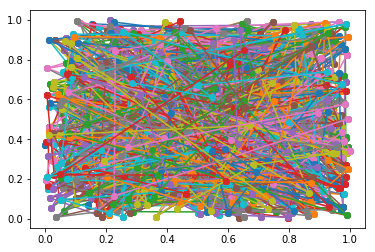

[-4.94180943 -9.03634937]
[-4.81551359 -9.1681686 ]
[-4.42771011 -9.23527196]
[-3.95384552 -9.20239837]
[-3.71090695 -9.47291486]
[-3.51512544 -9.69793164]
[-3.24243749 -9.7462688 ]
[-2.88184761 -9.41360982]
[-2.72126879 -9.22377436]
[-2.40239703 -9.56354162]
[-2.23963565 -9.65952553]
[-2.21942976 -9.16451239]
[-2.01849771 -9.04177032]
[-1.91889616 -8.88150275]
[-1.8258284  -8.74226616]
[-1.71139251 -8.66237619]
[-1.42931849 -8.61967735]
[-1.33902895 -8.51177307]
[-0.93443622 -8.3849219 ]
[-0.53259957 -8.35366155]
[-0.61121252 -8.11501978]
[-0.65105806 -7.69052801]
[-0.59752169 -7.53981721]
[-0.501459   -7.32987454]
[-0.32511771 -6.91206662]
[-0.33275585 -6.56968032]
[-0.27476469 -6.16776683]
[-0.36367012 -5.58217225]
[-0.79753433 -5.25039506]
[-1.09016059 -5.25236649]
[-4.77177004 -8.71511693]
[-4.5067952  -8.90604301]
[-4.15858832 -8.90157463]
[-3.92149279 -9.03834741]
[-3.63889608 -9.06388234]
[-3.48468297 -9.38458456]
[-3.15852415 -9.23990141]
[-2.87826222 -9.03534993]
[-2.70250105

[-4.0887542  -7.77409267]
[-4.05411348 -7.55825852]
[-4.01650442 -7.38142524]
[-3.95552733 -7.23931146]
[-3.88396879 -7.18402488]
[-3.82566473 -7.10266989]
[-3.72102726 -7.00502882]
[-3.66388994 -6.95585753]
[-3.61678995 -6.87031271]
[-3.56259601 -6.82338746]
[-3.49779826 -6.75336076]
[-3.43198371 -6.64952364]
[-3.38210444 -6.60144027]
[-3.32481557 -6.54053722]
[-3.26561564 -6.4965798 ]
[-3.19388431 -6.42914304]
[-3.10498304 -6.4001614 ]
[-3.0268542  -6.30371713]
[-2.95318899 -6.2319378 ]
[-2.87498829 -6.22068958]
[-2.79696959 -6.13950789]
[-2.6776698  -6.10507593]
[-2.60513493 -6.02524354]
[-2.49811282 -5.95101588]
[-2.41576038 -5.9043341 ]
[-2.25576827 -5.88761534]
[-2.08637937 -5.88069728]
[-1.97693357 -5.89795904]
[-1.7144765  -5.91741182]
[-4.14216491 -7.99483544]
[-4.15736078 -7.80812003]
[-4.13889127 -7.53538294]
[-4.11970113 -7.31136529]
[-4.05644597 -7.1871857 ]
[-3.98245521 -7.12970693]
[-3.89902915 -6.9983107 ]
[-3.81745095 -6.95614397]
[-3.78245346 -6.88059884]
[-3.70142146

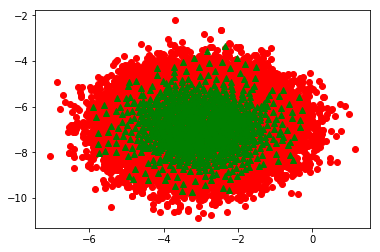

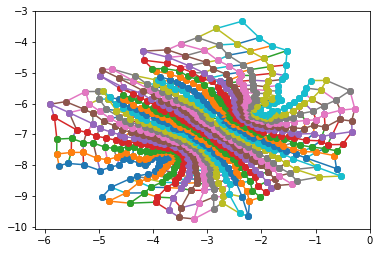

In [807]:
test_som = SOM(X, 2, 30, 30);
test_som.show_grid();
test_som.learn(X, 50000, 0.5);
test_som.plot();
test_som.show_grid();

In [ ]:
distance_array = np.array([2,7,4]) - np.array([5,6,7]);
distance_array = distance_array*distance_array; 
print(distance_array)
distance = np.sum(distance_array)
print(distance)
print(math.sqrt(distance))

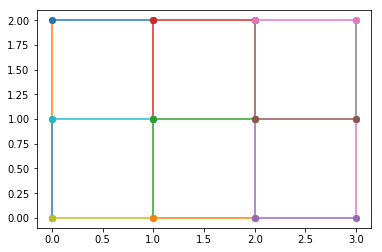

In [555]:
array = [[ 0, 0 ],[ 0,  1], [ 0,  2], 
         [ 1,  0], [ 1,  1], [ 1,  2],
         [ 2,  0], [ 2,  1], [ 2,  2],
         [ 3,  0], [ 3,  1], [ 3,  2]];

for j in range(0, 4):
    for i in range(0, 2):
        if i+3*j+1<len(array):
            plt.plot([array[i+3*j][0],array[i+3*j+1][0]], [array[i+3*j][1],array[i+3*j+1][1]], marker = 'o')
        
for j in range(0, 3):
    for i in range(0, 3):
        if (i+3*j+3)<len(array):
            plt.plot([array[i+3*j][0],array[i+3*j+3][0]], [array[i+3*j][1],array[i+3*j+3][1]], marker = 'o')

plt.show()

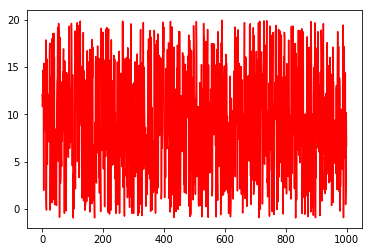

In [697]:
import matplotlib.pyplot as plt
s = np.random.uniform(-1,20,1000)
plt.plot(s, color='r')
plt.show()